### Notas del notebook

---------------
Hugo ||  Ultima modificacion: 11.05.2020 20:43 ||  Comentario: Cambios en la forma de seleccionar el dataframe

---------------
Hugo ||  Ultima modificacion: 12.05.2020 13:30 ||  Comentario: Proceso anterior para procesar DataFrame

--------------

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
from datetime import datetime, timedelta
#import os
import numpy as np
import itertools # para iterar las estrategias
import seaborn as sns
import mplfinance as mpf #prara grgaficar velas # https://github.com/matplotlib/mplfinance/tree/master/examples
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab # para ajustar el tamaño de los graficos

import warnings

warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = 20, 12 # Definimos el tamaño de los gráficos para que se ajusten bien al notebook
plt.style.use('ggplot')
%matplotlib inline

In [3]:
from datetime import time
from datetime import datetime
import time
import MetaTrader5 as mt5
import pandas as pd
import pytz
from IPython.display import clear_output


def VWMA_BB(data, wind, std1, std2):
    '''Funcion que calcula la vwma con un periodo determinado (wind), y sus 2 bandas de bollinguer, asociadas a 2 
    desviaciones estandar determinadas en la funcion como std1 y std2'''
    
    rolling_mean_prod = (data['close']*data['real_volume']).rolling(wind).sum()
    rolling_sum_vol = data['real_volume'].rolling(wind).sum()
    rolling_vwma = rolling_mean_prod / rolling_sum_vol
    
    rolling_std = rolling_vwma.rolling(wind).std()
        
    data['VWMA Rolling'] = rolling_vwma
    data['VWMA_BB High 1'] = rolling_vwma + (rolling_std * std1)
    data['VWMA_BB Low 1'] = rolling_vwma - (rolling_std * std1)
    data['VWMA_BB High 2'] = rolling_vwma + (rolling_std * std2)
    data['VWMA_BB Low 2'] = rolling_vwma - (rolling_std * std2)
    
    return data

# mostramos los datos sobre el paquete MetaTrader5

 
# importamos el módulo pandas para mostrar los datos obtenidos en forma de recuadro

pd.set_option('display.max_columns', 500) # cuántas columnas mostramos
pd.set_option('display.width', 1500)      # anchura máx. del recuadro para la muestra
# importamos el módulo pytz para trabajar con el huso horario

 
# establecemos la conexión con el terminal MetaTrader 5
#if not mt5.initialize(login=669047, server="AMPGlobalEU-Live",password="Heveterer2"):
#if not mt5.initialize(login=1148315, server="AMPGlobalUSA-Demo",password="x6juprku"):
if not mt5.initialize(login=1171263, server="AMPGlobalUSA-Demo",password="8czupjih"):
    print("initialize() failed, error code =",mt5.last_error())
    quit()

# establecemos el huso horario en UTC
timezone = pytz.timezone("Etc/UTC")
cont_oper = 0


print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)
print('------------------------------------------------------------')
print('Hora de envio: ' + str(datetime.now()))
utc_from = datetime.now()

# obtenemos 10 barras de EURUSD H4 a partir del 01.10.2020 en el huso horario UTC
rates = mt5.copy_rates_from("EPU20", mt5.TIMEFRAME_M5, utc_from, 9000)
# finalizamos la conexión con el terminal MetaTrader 5
mt5.shutdown()    

# creamos un DataFrame de los datos obtenidos
rates_frame = pd.DataFrame(rates)

# convertimos la hora en segundos al formato datetime
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
rates_frame['time']=rates_frame['time'] + timedelta(hours=+2)
rates_frame= rates_frame.drop(['tick_volume','spread'], axis=1)
rates_frame['time']= pd.to_datetime(rates_frame['time'], format = '%Y-%m-%d %H:%M:%S')
rates_frame = rates_frame.set_index(pd.DatetimeIndex(rates_frame['time']))
rates_frame= rates_frame.drop(['time'], axis=1)
rates_frame.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
rates_frame["Open"] = pd.to_numeric(rates_frame["Open"], downcast='float') 
rates_frame["Close"] = pd.to_numeric(rates_frame["Close"], downcast='float') 
rates_frame["High"] = pd.to_numeric(rates_frame["High"], downcast='float') 
rates_frame["Low"] = pd.to_numeric(rates_frame["Low"], downcast='float')  
rates_frame['Volume'] = pd.to_numeric(rates_frame['Volume'], downcast='float') 
rates_frame.tail()




MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.31
------------------------------------------------------------
Hora de envio: 2020-08-12 20:58:11.155751


,Open,High,Low,Close,Volume
time,,,,,
2020-08-12 21:35:00,3375.0,3376.50,3372.25,3376.25,17055.0
2020-08-12 21:40:00,3376.0,3379.25,3375.00,3378.25,17555.0
2020-08-12 21:45:00,3378.0,3378.75,3375.00,3376.25,14867.0
2020-08-12 21:50:00,3376.0,3378.50,3372.50,3374.00,27195.0
2020-08-12 21:55:00,3374.0,3376.00,3372.00,3374.75,14390.0


In [25]:

def SeccionDataframe(data, ini_date, n_day):
    '''SeccionDataframe(data, ini_date, n_day)
        Crea DataFrame a partir del original con los datos a partir de una 
        fecha y un numero n de dias
        
        Parametros
        --------
        data: DataFrame, DataFrame original que queremos seccionar
        
        ini_date: str, fecha a partir de la que queremos comenzar
        
        n_day: int, numero de dias que queremos a partir de la fecha
        
        Returns
        --------
        DataFrame

            Se devuelve un DataFrame despues de filtrarlo
            
        Examples
        --------
        >>> SeccionDataframe('df, '2017-10-22', 30)'''
    
    date_time_obj = datetime.datetime.strptime(ini_date, '%Y-%m-%d')

    start = pd.to_datetime(date_time_obj.date())

    end_date = start + datetime.timedelta(days = n_day)
    
    # filtro: muestra los valores entre la fecha inicial y la final
    mask = (data.index > ini_date) & (data.index <= end_date)

    return data.loc[mask]

def VWMA_BB_restart_diario(data, std1, std2):
    '''Funcion que calcula la vwma en periodo diario, expandiendose +1 con cada vela que pasa, y sus 2 bandas de bollinguer, asociadas a 2 
    desviaciones estandar determinadas en la funcion como std1 y std2'''
    
    
    rolling_vwma = data.eval('wgtd = Close * Volume', inplace=False).groupby(data.index.date).cumsum().eval('wgtd / Volume')
    
    rolling_std = (rolling_vwma.groupby(data.index.date).expanding()).std().droplevel(0)
        
    data['VWMA Rolling'] = rolling_vwma
    data['VWMA_BB High 1'] = rolling_vwma + (rolling_std * std1)
    data['VWMA_BB Low 1'] = rolling_vwma - (rolling_std * std1)
    data['VWMA_BB High 2'] = rolling_vwma + (rolling_std * std2)
    data['VWMA_BB Low 2'] = rolling_vwma - (rolling_std * std2)
    
    return data

def estrategia_prueba_1_01 (df, SL, SD1, x, y, z):
    '''Funcion del algoritmo de la estrategia. SL= Tamano de stop lost
                                                SD1= desviacion estandar
                                                x= angulo de incluinacion de la vwma a partir del cual si es menor efectua estrategia lateral
                                                y= Ratio Riesgo beneficio en funcion del SL
                                                z= distancia sumada a x, a partir de la cual tomara como estrategia tendencial'''
    
    
    def resultado_estrategia (estr1, parametros):
        '''Analisis de la rentabilidad del algoritmo principal'''
        resultados = parametros 
        resultados['Beneficio Bruto'] = round(estr1['Resultados acumulados'][-1],2)*50


        resultados['Máximo Drawdown'] = round((estr1['Resultados acumulados'].div(estr1['Resultados acumulados'].cummax()).sub(1)).min(),2)
                                        
        resultados['Número de trades'] = len(estr1.Resultados[estr1.Resultados!=0])


        resultados['Num Trades Ganadores'] = estr1.loc[estr1.Resultados>0,'Resultados'].count()
        resultados['Num Trades Perdedores'] = estr1.loc[estr1.Resultados<0,'Resultados'].count()
        resultados['Ratio Acierto'] = round(100 * resultados['Num Trades Ganadores'] / resultados['Número de trades'], 2)


        return resultados

    
    
    
    estr = df.copy()
    estr1 = VWMA_BB_restart_diario(estr, SD1 ,SD1*2)
    TP = SL * y
    com = 0.15 #comisiones
    
        # 0 Open    5 VWMA Rolling      10 Estado                
        # 1 High   6 VWMA_BB High 1    11 Precioapertura
        # 2 Low   7 VWMA_BB Low 1     12 Resultados
        # 3 Close    8 VWMA_BB High      13 Restuldos acumula
        # 4 Volume  9 VWMA_BB Low 2    14 tendencia
      
        
    #Esto crea las columnas con determinado valor en todas ellas
    (estr1['Estado'], estr1['Precio apertura operacion'], estr1['Resultados'], estr1['Resultados acumulados'], estr1['tendencia']) = 0, 0, 0, 100, None
    #redefinimos los valores que han de tener en cada una de ellas
    estr1['Resultados'] = pd.to_numeric(estr1['Resultados'], downcast='float')
    estr1['Resultados acumulados'] = pd.to_numeric(estr1['Resultados acumulados'], downcast='float')
    estr1['Precio apertura operacion'] = pd.to_numeric(estr1['Precio apertura operacion'], downcast='float')
    #Creamos contador de velas en el rango diario
    estr1['counter'] = 1
    estr1['counter1'] = estr1['counter'].groupby(estr1.index.date).cumsum()
    
    
    
    #Iteracion en cada una de las velas.
    for row in range(len(estr1)):
        c_tend_lateral = (abs(estr1.iat[row,5] - estr1.iat[row-4,5]) <= x)#Condicion para definir tendencia lateral
        c_tend_tendencial = (abs(estr1.iat[row,5] - estr1.iat[row-4,5]) > x+z)#Condicion para definir tendencia ascendente o descendente
        
#______________________________________________________________________LATERAL____________________________________________________________________

        if c_tend_lateral: #estrategia lateral
            #indicamos tendencia
            estr1.iat[row, 14] = 'lateral'
            #condiciones de apertura
            c_open_lwr_low1_vwma = ((estr1.Close.iloc[row-3:row-1].mean() < estr1.iat[row, 0]) & (estr1.iat[row, 0] <= estr1.iat[row-1, 7]))#Condicion compra: si precio close se encuentra por arriba de la media de los 3 ultimos closes & si el precio close esta por debajo o igual a la banda de bolinguer inferior
            c_open_bgr_high1_vwma = ((estr1.Close.iloc[row-3:row-1].mean() > estr1.iat[row, 0]) & (estr1.iat[row, 0] >= estr1.iat[row-1, 6]))#Condicion venta: si precio close se encuentra por debajo de la media de los 3 ultimos closes & si el precio close esta por arriba o igual a la banda de bolinguer inferior
            #COndiciones de cierre
            
            #grupo para misma vela
            c_low_lwr_prec_apert_op_sl1 = estr1.iat[row, 2] <= estr1.iat[row, 0] - SL
            c_low_lwr_prec_apert_op_tp1 = estr1.iat[row, 2] <= (estr1.iat[row, 0] - TP)
            c_hgh_bgr_prec_apert_op_tp1 = estr1.iat[row, 1] >= (estr1.iat[row, 0] + TP)
            c_hgh_bgr_prec_apert_op_sl1 = estr1.iat[row, 1] >= (estr1.iat[row, 0] + SL) 
            #grupo para velas consecutivas sin cerrar
            c_low_lwr_prec_apert_op_sl = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - SL)
            c_low_lwr_prec_apert_op_tp = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - TP)
            c_hgh_bgr_prec_apert_op_tp = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + TP)
            c_hgh_bgr_prec_apert_op_sl = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + SL)
            #Condicion de retraso en el dia de inicio de estrategia
            c_delay_diario = estr1.iat[row, 16] >= 80
        #----------------------------------------------------------------------------------------------------------------------------------------
            #Check para abrir operacion o seguir sin abrir
            if (estr1.iat[row-1, 10] == 0):
                if (c_open_bgr_high1_vwma)&(c_delay_diario):
                    estr1.iat[row, 10] = -1 
                    estr1.iat[row, 11] = estr1.iat[row, 0]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                elif (c_open_lwr_low1_vwma)&(c_delay_diario):
                    estr1.iat[row, 10] = +1
                    estr1.iat[row, 11] = estr1.iat[row, 0]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                else:
                    estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

            #Si abrimos y se cumple la condicion de cierre en una misma vela:
            if (estr1.iat[row-1, 10] == 0): 

                if (estr1.iat[row, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl1):
                        estr1.iat[row, 10]  = 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue


                if (estr1.iat[row, 10] == -1):#estamos en venta
                    if (c_hgh_bgr_prec_apert_op_sl1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue

            #si el cierre no se produce en la misma vela de apertura sino en las consecutivas:
            else:        

                if (estr1.iat[row-1, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]


                if (estr1.iat[row-1, 10] == -1):#estamos en venta
                    if (c_hgh_bgr_prec_apert_op_sl).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = -SL - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = TP - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                            estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                            estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                            estr1.iat[row, 13] = estr1.iat[row-1, 13]

#_________________________________________________________________Tendencial_____________________________________________________________________

        elif c_tend_tendencial:#estrategia tendencial

            estr1.iat[row, 14] = 'tendencial'
        
            c_open_hgr_low1_vwma_t = ((estr1.Close.iloc[row-3:row-1].mean() > estr1.iat[row, 0]) & (estr1.iat[row, 0] >= estr1.iat[row-1, 7]))
            c_open_lwr_high1_vwma_t = ((estr1.Close.iloc[row-3:row-1].mean() < estr1.iat[row, 0]) & (estr1.iat[row, 0] <= estr1.iat[row-1, 6]))
            
            c_low_lwr_prec_apert_op_sl1 = estr1.iat[row, 2] <= (estr1.iat[row, 0] - SL)
            c_low_lwr_prec_apert_op_tp1 = estr1.iat[row, 2] <= (estr1.iat[row, 0] - TP)
            c_hgh_bgr_prec_apert_op_tp1 = estr1.iat[row, 1] >= (estr1.iat[row, 0] + TP)
            c_hgh_bgr_prec_apert_op_sl1 = estr1.iat[row, 1] >= (estr1.iat[row, 0] + SL) 

            c_low_lwr_prec_apert_op_sl = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - SL)
            c_low_lwr_prec_apert_op_tp = estr1.iat[row, 2] <= (estr1.iat[row-1, 11] - TP)
            c_hgh_bgr_prec_apert_op_tp = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + TP)
            c_hgh_bgr_prec_apert_op_sl = estr1.iat[row, 1] >= (estr1.iat[row-1, 11] + SL)
            
            c_delay_diario = (estr1.iat[row, 16] >= 80)
            
            if (estr1.iat[row-1, 10] == 0):
                if (c_open_hgr_low1_vwma_t)&(c_delay_diario):
                    estr1.iat[row, 10] = -1 
                    estr1.iat[row, 11] = estr1.iat[row, 0]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                elif (c_open_lwr_high1_vwma_t)&(c_delay_diario):
                    estr1.iat[row, 10] = +1
                    estr1.iat[row, 11] = estr1.iat[row, 0]
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]

                else:
                    estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]
                    
                    
                    
            if (estr1.iat[row-1, 10] == 0): #todo esto es analisis en la misma fila 

                if (estr1.iat[row, 10] == 1):#estamos en compra
                    if (c_low_lwr_prec_apert_op_sl1):
                        estr1.iat[row, 10]  = 0
                        estr1.iat[row, 12] = -SL - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue                            

                if (estr1.iat[row, 10] == -1):#estamos en venta
                    if (c_hgh_bgr_prec_apert_op_sl1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp1):
                        estr1.iat[row, 10]= 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]
                    else:
                        continue
                               
            else:#analisis fila anterior        

                if (estr1.iat[row-1, 10] == 1):#estamos en compra
                               
                    if (c_low_lwr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                        estr1.iat[row, 12] = -SL - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                    elif (c_hgh_bgr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]




                if (estr1.iat[row-1, 10] == -1):
                    if (c_hgh_bgr_prec_apert_op_sl).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = -SL - com
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    elif (c_low_lwr_prec_apert_op_tp).all():
                            estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                            estr1.iat[row, 12] = TP - com 
                            estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                    else:
                            estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                            estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                            estr1.iat[row, 13] = estr1.iat[row-1, 13]      
                            
                            
#______________________SI NO ESTAMOS EN TENDENCIA LATERAL NI TENDENCIAL, solo cerramos operaciones ya abiertas, o transladamos info_________________________________

        else:   
            
            if (estr1.iat[row-1, 10] == 0):#no hay operacion abierta
                estr1.iat[row, 10], estr1.iat[row, 11], estr1.iat[row, 12] = 0, 0, 0 
                estr1.iat[row, 13] = estr1.iat[row-1, 13]
                
                
            if (estr1.iat[row-1, 10] == 1):#estamos en compra

                if (c_low_lwr_prec_apert_op_sl).all():
                    estr1.iat[row, 10], estr1.iat[row, 11]  = 0, 0
                    estr1.iat[row, 12] = -SL - com 
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]+ estr1.iat[row, 12]

                elif (c_hgh_bgr_prec_apert_op_tp).all():
                    estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                    estr1.iat[row, 12] = TP - com
                    estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                else:
                    estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                    estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                    estr1.iat[row, 13] = estr1.iat[row-1, 13]


            if (estr1.iat[row-1, 10] == -1):#estamos en venta
                if (c_hgh_bgr_prec_apert_op_sl).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = -SL - com
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                elif (c_low_lwr_prec_apert_op_tp).all():
                        estr1.iat[row, 10], estr1.iat[row, 11] = 0, 0
                        estr1.iat[row, 12] = TP - com 
                        estr1.iat[row, 13] = estr1.iat[row-1, 13] + estr1.iat[row, 12]

                else:
                        estr1.iat[row, 10] = estr1.iat[row-1, 10] #vela anterior
                        estr1.iat[row, 11] = estr1.iat[row-1, 11]#vela anterior
                        estr1.iat[row, 13] = estr1.iat[row-1, 13]           
            

            
                       
    parametros = {'Stop Lost' : SL, '1º desviacion estandar' : SD1, 'Angulo cambio tendencia' : x, 'Ratio B/P' : y, 'espacio entre tendencias' : z}                         
    resultados = resultado_estrategia(estr, parametros)
    
    return estr1, resultados

In [26]:
pro = estrategia_prueba_1_01 (rates_frame, 5, 1.8, 0.5, 4, 3)
pro[0].to_excel('mecagoentodo.xls')

In [27]:
import mplfinance as mpf #prara grgaficar velas
# https://github.com/matplotlib/mplfinance/tree/master/examples
# En esta pagina puedes consultar la documentacion de esta libreria

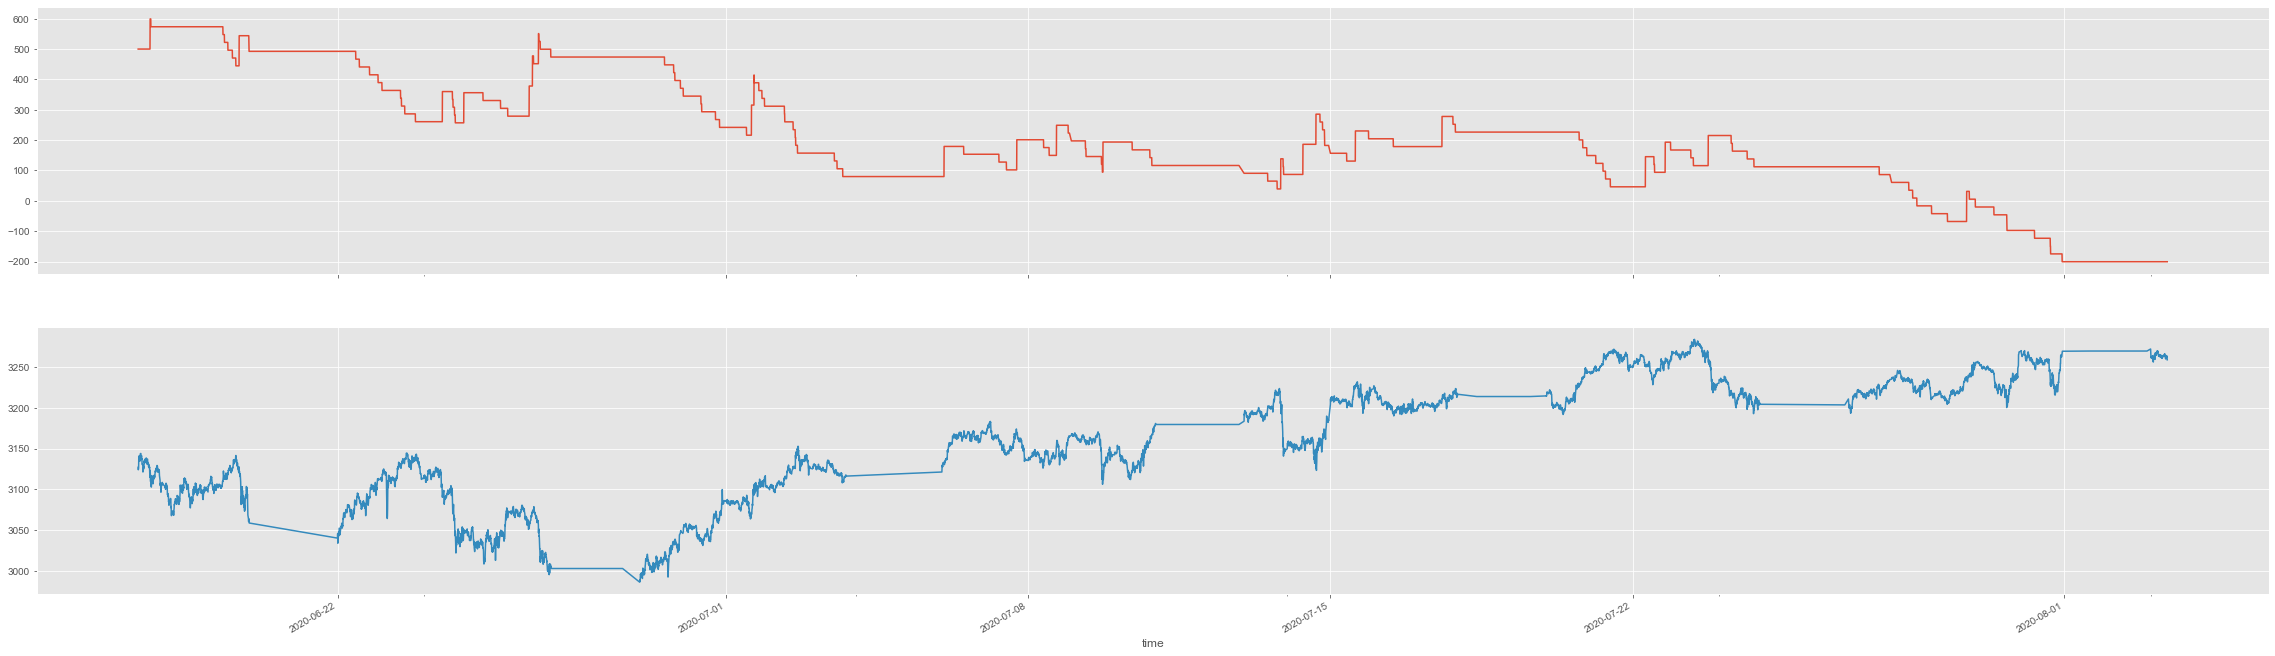

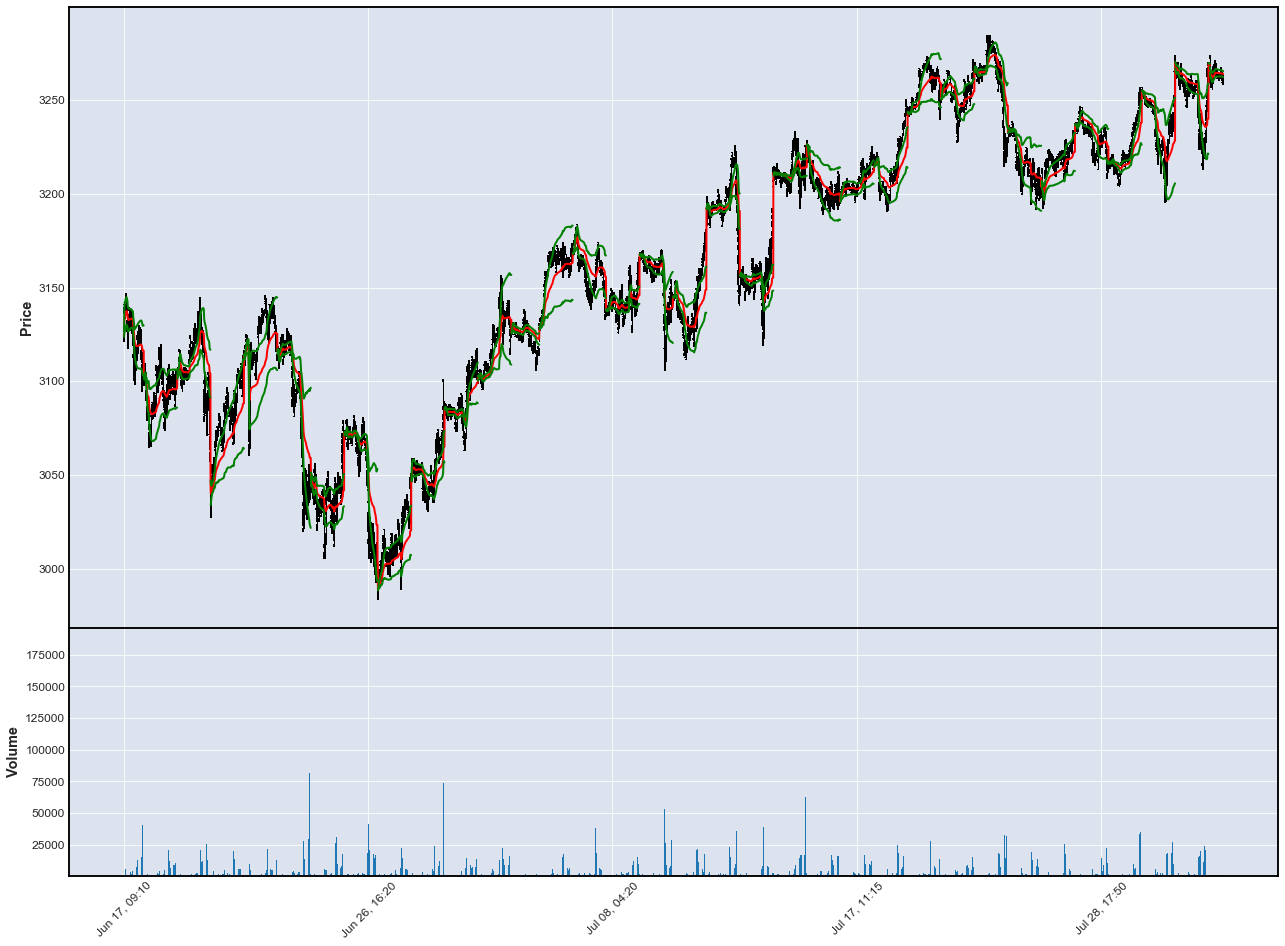

(                        Open     High      Low    Close  Volume  VWMA Rolling  VWMA_BB High 1  VWMA_BB Low 1  VWMA_BB High 2  VWMA_BB Low 2  Estado  Precio apertura operacion  Resultados  Resultados acumulados   tendencia  counter  counter1
 time                                                                                                                                                                                                                                            
 2020-06-17 09:10:00  3127.00  3129.25  3122.75  3124.00  3024.0   3124.000000             NaN            NaN             NaN            NaN       0                       0.00         0.0             500.000000  tendencial        1         1
 2020-06-17 09:15:00  3124.00  3128.75  3121.00  3125.75  3615.0   3124.952881     3126.165700    3123.740062     3127.378520    3122.527242       0                       0.00         0.0             500.000000  tendencial        1         2
 2020-06-17 09:20:00  3125.50  3

In [28]:
pro[0]['Resultados acumulados'] = pro[0]['Resultados acumulados']*5
pro[0][['Resultados acumulados','Open']].plot(subplots = True, grid = True, legend = False, figsize=(40, 12))
bb_r_vwma = mpf.make_addplot(pro[0]['VWMA Rolling'],color='red')
bb_high1 = mpf.make_addplot(pro[0]['VWMA_BB High 1'],color='green')
bb_low1 = mpf.make_addplot(pro[0]['VWMA_BB Low 1'],color='green')
indicadores = [bb_r_vwma, bb_high1, bb_low1]
mpf.plot(pro[0], type = 'candle', figscale = 3, volume = True, addplot = indicadores)

pro